In [1]:
import os
import math
import pickle
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras import optimizers

from functools import partial
from multiprocessing import Pool
from collections import namedtuple
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from scipy.stats import pearsonr

In [2]:
begin = datetime.datetime.now()

In [3]:
def generate_single_region_dataset(key, region_data, look_back, look_forward, x_columns, y_columns=None, gen_x=True, gen_y=True):
    
    # Check region dataframe
    if region_data is None:
        print('generate_single_region_dataset error: Region data is None!')
        return (None, None)
    
    # Check number of regions
    if len(region_data[key].unique()) > 1:
        print('generate_single_region_dataset error: More than one region in the dataframe!')
        return (None, None)
    else:
        region_name = region_data[key].unique()[0]
    
    # Drop 'Region' column
    region_data = region_data.drop(columns=key)
    
    # Check the number of samples available to
    # generate the look back and look forward windows
    if len(region_data) < (look_back + look_forward):
        print('generate_single_region_dataset error: Not enough samples '+
              'in {} to generate the windows!'.format(region_name))
        return (None, None)
    
    n_samples = len(region_data) - look_back - look_forward + 1

    var_names = x_columns
    
    # Generate inputs
    if gen_x:
        inputs = pd.DataFrame()
        
        for i in range(n_samples):
            input_window = region_data.T.iloc[:, i:i+look_back]
            wide_input_sample = pd.DataFrame()
            
            for var in var_names:
                var_input_sample = input_window.loc[var:var, :]
                var_input_sample.columns = ['{}_t{}'.format(var, a) for a in range(1-look_back, 1)]
                var_input_sample = var_input_sample.reset_index(drop=True)
                wide_input_sample = pd.concat([wide_input_sample, var_input_sample], axis='columns')
                
            inputs = pd.concat([inputs, wide_input_sample], axis='index')
            
        # Insert region name
        #inputs.insert(loc=0, column=key, value=region_name)
        # Reset index
        inputs = inputs.reset_index(drop=True)

    # Generate outputs
    if gen_y:
        
        if y_columns is None:
            print('generate_single_region_dataset error: Need to specify column labels!')
            return (None, None)
        
        var_names = y_columns
        outputs = pd.DataFrame()
        
        for i in range(n_samples):
            output_window = region_data.T.iloc[:, i+look_back : i+look_back+look_forward]
            wide_output_sample = pd.DataFrame()

            for var in var_names:
                var_output_sample = output_window.loc[var:var, :]
                var_output_sample.columns = ['{}_t+{}'.format(var, a) for a in range(1, look_forward+1)]
                var_output_sample = var_output_sample.reset_index(drop=True)
                wide_output_sample = pd.concat([wide_output_sample, var_output_sample], axis='columns')

            outputs = pd.concat([outputs, wide_output_sample], axis='index')
        
        # Insert region name
        #outputs.insert(loc=0, column=key, value=region_name)
        # Reset index
        outputs = outputs.reset_index(drop=True)
        
    if gen_x and gen_y:
        return (inputs, outputs)
    elif gen_x:
        return (inputs, None)
    elif gen_y:
        return (None, outputs)

In [4]:
def _get_single_region_dataset(args, region_name):
    
    key = args[0]
    regions_data = args[1]
    
    region_data = regions_data[regions_data[key]==region_name]
    
    new_args = args.copy()
    new_args[1] = region_data
    
    region_x, region_y = generate_single_region_dataset(*new_args)
    
    return (region_x, region_y)

In [5]:
def generate_regions_dataset(key, regions_data, look_back, look_forward, x_columns, y_columns=None, 
                             gen_x=True, gen_y=True):
    
    regions_names = regions_data[key].unique()
    
    all_regions_x = pd.DataFrame()
    all_regions_y = pd.DataFrame()
    
    args = [key, regions_data, look_back, look_forward, x_columns, y_columns, gen_x, gen_y]
    
    func_gen_region_dataset = partial(
        _get_single_region_dataset,
        args
    )
    
    n_jobs = os.cpu_count()
    
    chunk = max(1, (int(len(regions_names)/n_jobs)))
    
    with Pool(n_jobs) as pool:
        datasets_list = pool.map(func_gen_region_dataset, regions_names, chunksize=chunk)
        
    for dataset in datasets_list:
        
        region_x = dataset[0]
        region_y = dataset[1]
        
        if not (region_x is None):
            all_regions_x = pd.concat([all_regions_x, region_x])
            all_regions_x = all_regions_x.reset_index(drop=True)
            
        if not (region_y is None):
            all_regions_y = pd.concat([all_regions_y, region_y])
            all_regions_y = all_regions_y.reset_index(drop=True)
    
    if gen_x and gen_y:
        return (all_regions_x, all_regions_y)
    elif gen_x:
        return (all_regions_x, None)
    elif gen_y:
        return (None, all_regions_y)

### Funções para carregamento dos dados de entrada dos modelos treinados com dados sintéticos

In [6]:
def input_ID(df):
    lista_regiao = list(df["Country/Region"].unique())
    identificadores = np.arange(0,len(lista_regiao))
    lista_df = []
    l=0
    for i in lista_regiao:
        
        mask = df['Country/Region'] == i
        df_temp = df.loc[mask]
        df_temp.insert(0, "ID", identificadores[l] )
        lista_df.append(df_temp)
        l=l+1
    df_final = pd.concat(lista_df) 
    return df_final

In [7]:
def create_PT_multi(sequences, n_steps_in, n_steps_out):
    #Função pare desenvolvimento dos preditores
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out-1
        # check if we are beyond the dataset
        if out_end_ix >= len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix:out_end_ix+1, -1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [8]:
def preditores_targets(np_treino, vp, vf):
    identificador = np.unique(np_treino[:,0], axis=0)  
    lista_treinoX = []
    lista_treinoY = []
    for i in identificador:
        
        mask = np_treino[:,0] ==i
        dados_treino_temp = np_treino[mask]
        dados_treino_temp = dados_treino_temp[:,1:]
        
        if(vp + vf <= dados_treino_temp.shape[0]):
            treinamentoX_full, treinamentoY_full = create_PT_multi(dados_treino_temp, vp, vf) 
            lista_treinoX.append(treinamentoX_full)
            lista_treinoY.append(treinamentoY_full)
        else:
            print("A serie temporal com identificação "+ str(i) + " não foi considerada (poucos dados)")
    
    preditores = np.concatenate(lista_treinoX)
    targets = np.concatenate(lista_treinoY)
    
    return preditores, targets

### Função para cálculo do Fator de 2

In [9]:
def get_fac2(y_true, y_pred):
    min_ = 0.5
    max_ = 2
    
    eps = np.finfo(np.float).eps
    
    division = y_pred / (y_true+eps)
    
    greater_min = np.greater_equal(division, min_)
    less_max = np.less_equal(division, max_)

    res = np.equal(greater_min, less_max)
    res = res.astype(float)

    fac_2 = res.mean()

    return fac_2

### Função para cálculo de métricas do modelo em cada horizonte de previsão

In [10]:
def get_metrics(y_true, y_pred, filename=None):
    
    metrics = pd.DataFrame(columns=['MSE', 'RMSE', 'MAE', 'Pearson r', 'Fac2'])
    
    n_cols = y_true.shape[1]
    
    for col in range(n_cols):
        y_true_col = y_true.iloc[:, col]
        y_pred_col = y_pred.iloc[:, col]

        if y_true_col.name == y_pred_col.name:
            col_name = y_true_col.name
        else:
            print('Column name error.')
            return None

        mse = mean_squared_error(y_true_col, y_pred_col)
        rmse = mean_squared_error(y_true_col, y_pred_col, squared=False)
        mae = mean_absolute_error(y_true_col, y_pred_col)
        pearson_r = pearsonr(y_true_col, y_pred_col)[0]
        fac2 = get_fac2(y_true_col.values, y_pred_col.values)
        
        metrics.loc[col_name, :] = [mse, rmse, mae, pearson_r, fac2]

    metrics.loc['Average', :] = metrics.mean()
    
    return metrics

### Função para plotar métricas do modelo em cada horizonte de previsão

In [11]:
def plot_metrics(dict_metrics, title='', xlabel='', ylabel=''):
    
    plt.figure(figsize=(14, 12))
    plt.suptitle(title, fontsize=14, y=0.935)
    
    keys = list(dict_metrics.keys())
    key_0 = keys[0]
    metrics_df_0 = dict_metrics[key_0]
    metrics_names = metrics_df_0.columns
    time_steps = list(range(1, metrics_df_0.shape[0]))
    
    for col, metric_name in enumerate(metrics_names):
        
        plt.subplot(3, 2, col+1)
        
        for key in dict_metrics.keys():
            
            metrics_df = dict_metrics[key]
            plt.plot(time_steps, metrics_df.iloc[0:-1, col], marker='o', label=key)
        
        plt.title('{} para cada horizonte de previsão'.format(metric_name))
        plt.legend()
        plt.xlabel('Dias a frente', fontsize=10)
        plt.ylabel(metric_name, fontsize=10)
        plt.xlim(left=time_steps[0], right=time_steps[-1])
        plt.xticks(np.linspace(time_steps[0], time_steps[-1], num=5, dtype=int))
        
    plt.subplots_adjust(wspace=0.2, hspace=0.4)
    plt.show()

### Função para plotar média das métricas de todos horizontes de previsão do modelo

In [12]:
def plot_average_metrics(dict_metrics, title=''):
    
    plt.figure(figsize=(14, 15))
    plt.suptitle(title, fontsize=14, y=0.935)
    
    keys = list(dict_metrics.keys())
    key_0 = keys[0]
    metrics_df_0 = dict_metrics[key_0]
    metrics_names = metrics_df_0.columns
    
    for col, metric_name in enumerate(metrics_names):
        
        plt.subplot(3, 2, col+1)
        
        for i, key in enumerate(dict_metrics.keys()):
            
            metrics_df = dict_metrics[key]
            
            metric_val = metrics_df.loc['Average', metric_name]
            
            container = plt.bar(i, metric_val, label=key)
            
            annotatation_x = container.patches[0].get_x() + container.patches[0].get_width() / 2
            
            plt.annotate('{:.2f}'.format(metric_val),
                         xy=(annotatation_x, metric_val),
                         xytext=(0, 3),  # 3 points vertical offset
                         textcoords='offset points',
                         ha='center', va='bottom')
            
        plt.title('{} - Média de todos horizontes de previsão'.format(metric_name))
#         plt.legend()
        plt.ylabel(metric_name, fontsize=10)
        y_limits = plt.ylim()
        plt.ylim(y_limits[0], y_limits[1]+y_limits[1]*0.08)
        plt.xticks(np.arange(len(dict_metrics.keys())), list(dict_metrics.keys()), rotation=45)
        
    plt.subplots_adjust(wspace=0.2, hspace=0.6)
    plt.show()

### Função para plotar gráficos de dispersão entre valores reais e preditos para cada horizonte de previsão

In [13]:
def plot_scatter(y_true, y_pred, title=''):
    
    plt.figure(figsize=(14, 28))
    plt.suptitle(title, fontsize=14, y=0.915)
    
    n_cols = y_true.shape[1]
    
    for col in range(n_cols):
        
        max_val = max(y_true.iloc[:, col].max(), y_pred.iloc[:, col].max())
        min_val = min(y_true.iloc[:, col].min(), y_pred.iloc[:, col].min())
                
        max_lim = max_val + max_val*0.05
        max_lim = math.ceil(max_lim)
        
        ndigits = len(str(max_lim))
        max_lim = int(math.ceil(max_lim / (10.0**(ndigits-2)) )) * (10.0**(ndigits-2))
        
        min_lim = min_val - max_val*0.05
        min_lim = max(0, min_lim)
        
        plt.subplot(8, 4, col+1)
        plt.title('Previsões para t+{}'.format(col+1))
        plt.scatter(y_true.iloc[:, col], y_pred.iloc[:, col])
        plt.xlabel('Real', fontsize=10)
        plt.ylabel('Previsão', fontsize=10)
        
        plt.xlim(left=min_lim, right=max_lim)
        plt.ylim(top=max_lim, bottom=min_lim)
        
        plt.xticks(np.linspace(min_lim, max_lim, num=5, dtype=int))
        plt.yticks(np.linspace(min_lim, max_lim, num=5, dtype=int))

        plt.plot([min_lim, max_lim], [min_lim, max_lim])
        
    plt.subplots_adjust(wspace=0.5, hspace=0.5)
    plt.show()

### Função para plotar valores reais e preditos em cada horizonte de previsão

In [14]:
def plot_samples(y_true, y_pred, title='', xlabel='', ylabel=''):
    
    plt.figure(figsize=(14, 28))
    plt.suptitle(title, fontsize=14, y=0.915)
    
    n_cols = y_true.shape[1]
    
    for col in range(n_cols):
        
        days = list(range(col+1, (col+1)+len(y_true)))
        
        plt.subplot(8, 4, col+1)
        plt.title('Previsões para t+{}'.format(col+1))
        plt.plot(days, y_true.iloc[:, col], label='Real')
        plt.plot(days, y_pred.iloc[:, col], label='Previsão')
        plt.legend()
        plt.xlabel(xlabel, fontsize=10)
        plt.ylabel(ylabel, fontsize=10)
        plt.xlim(left=days[0], right=days[-1])
        plt.xticks(np.linspace(days[0], days[-1], num=5, dtype=int))
        
    plt.subplots_adjust(wspace=0.5, hspace=0.5)
    plt.show()

### Classe para gerenciamento dos modelos de base

In [15]:
class BaseModelsConfirmed:
    
    def __init__(self, base_path):
        
        self.load_models(base_path)
    
    def _load_artifacts(self, model_path):
        
        with open('{}/x_scaler.pkl'.format(model_path), 'rb') as scaler_file:
            x_scaler = pickle.load(scaler_file)

        with open('{}/y_scaler.pkl'.format(model_path), 'rb') as scaler_file:
            y_scaler = pickle.load(scaler_file)

        model = keras.models.load_model('{}/model.h5'.format(model_path))
        
        artifacts = {'x_scaler':x_scaler, 'y_scaler':y_scaler, 'model':model}
        
        artifacts = namedtuple('Artifacts', artifacts.keys())(*artifacts.values())
        
        return artifacts
    
    def load_models(self, base_path):
        
        model_paths = os.listdir(base_path)
        
        models = dict()
        
        for model_path in model_paths:
            
            model_artifacts = self._load_artifacts('{}/{}'.format(base_path,model_path))
            models[model_path] = model_artifacts
        
        self.models = namedtuple('Models', models.keys())(*models.values())
        
    def transform_x_data(self, x_data, model_name):
        
        model_artifacts = getattr(self.models, model_name)
        
        x_data_scaled = model_artifacts.x_scaler.transform(x_data)
        
        return x_data_scaled
        
    def inverse_transform_y_data(self, y_data_scaled, model_name):
        
        model_artifacts = getattr(self.models, model_name)
        
        y_data = model_artifacts.y_scaler.inverse_transform(y_data_scaled)
        
        return y_data
        
    def reshape_x_data(self, x_data, model_name, lookback=4, lookforward=0):
        
        if model_name == 'CNN_LSTM_real':
            x_columns = 10
            
            new_x_data = np.empty([x_data.shape[0], lookback, x_columns])
            
            k = 0
            for i in range(x_columns):
                for j in range(lookback):
                    new_x_data[:, j, i] = x_data[:, k]
                    k = k + 1
        
        elif model_name == 'LSTM_real':
            
            new_x_data = np.reshape(x_data, (x_data.shape[0], 1, x_data.shape[1]))
            
        elif (model_name=='LSTM_sintetico') or (model_name=='CNN_LSTM_sintetico'):
            
            new_x_data, _ = preditores_targets(x_data, lookback, lookforward)
        
        else:
            print('BaseModels.reshape_x_data error. Model name not defined.')
            return None
        
        return new_x_data
    
    def model_predict(self, dataset, model_name, lookback=4, lookforward=0, scale=True):
        
        if (model_name=='LSTM_real') or (model_name=='CNN_LSTM_real'):
            
            x_columns = ["Deaths", "Confirmed", "C1","C2","C3","C4","C5","C6","C7","C8"]
            y_columns = ["Confirmed"]
            
            # Gera dados de entrada para o modelo com colunas de lookback
            x_data, _ = generate_regions_dataset(
                "Country/Region", dataset, lookback, lookforward, x_columns, y_columns=y_columns,
                gen_x=True, gen_y=False
            )
                
        elif (model_name=='LSTM_sintetico') or (model_name=='CNN_LSTM_sintetico'):
            
            # Insere coluna ID com IDs para cada região do DataFrame
            dataset_id = input_ID(dataset)
            
            # Formatando colunas de interesse na ordem correta
            x_columns = ["ID","Deaths", "Confirmed", "C1","C2","C3","C4","C5","C6","C7","C8"]
            y_columns = ["Confirmed"]
            cols_sequence = x_columns + y_columns
            x_data = dataset_id[cols_sequence]
            
        else:
            print('BaseModels.model_predict error. Model name not defined.')
            return None
        
        x_data_scaled = self.transform_x_data(x_data, model_name)
        
        new_x_data = self.reshape_x_data(x_data_scaled, model_name, lookback, lookforward)
        
        model_artifacts = getattr(self.models, model_name)
        y_pred = model_artifacts.model.predict(new_x_data)    
        
        if scale:
            y_pred = self.inverse_transform_y_data(y_pred, model_name)
        
        return y_pred
    
    def predict(self, dataset, lookback=4, lookforward=0, scale=False):
        
        models_names = self.models._fields
        n_models = len(models_names)
        
        models_preds = []
        
        for model_name in models_names:
            
            y_pred = self.model_predict(
                dataset, model_name, lookback=lookback, lookforward=lookforward, scale=scale
            )
            
            models_preds.append(y_pred)
            
        y_preds = np.hstack(models_preds)
        
        y_preds = np.reshape(y_preds, (y_preds.shape[0], 30, n_models), order='F')
        
        return y_preds

### Classe para gerenciamento do metamodelo

In [16]:
class MetaModelConfirmed:
    
    def __init__(self, base_path, metamodel_path):
        
        self.base_models = BaseModelsConfirmed(base_path)
        
        self.load_model(metamodel_path)
        
    def load_model(self, metamodel_path):
        
        with open('{}/meta_y_scaler.pkl'.format(metamodel_path), 'rb') as scaler_file:
            self.meta_y_scaler = pickle.load(scaler_file)

        self.metamodel = keras.models.load_model('{}/metamodel.h5'.format(metamodel_path))
    
    def predict(self, x_data, lookback=4, lookforward=0, scale=True):
        
        base_pred = self.base_models.predict(x_data, lookback=lookback, lookforward=lookforward)
        
        meta_pred = self.metamodel.predict(base_pred)
        
        if scale:
            meta_pred = self.meta_y_scaler.inverse_transform(meta_pred)
        
        return meta_pred

### Carregando dados atualizados

In [17]:
complete_dataset = pd.read_csv('../dataset/complete_20200821.csv')

### Criando datasets

In [18]:
lookback = 4
lookforward= 30

x_columns = ["Deaths", "Confirmed", "C1","C2","C3","C4","C5","C6","C7","C8"]
y_columns = ["Confirmed"]

_, y_complete = generate_regions_dataset(
    "Country/Region", complete_dataset, lookback, lookforward, x_columns, y_columns=y_columns,
    gen_x=False, gen_y=True
)

# Comparação das métricas dos modelos com dados completos

In [19]:
metamodel = MetaModelConfirmed('base_models', 'CNN_LSTM_metamodel')

/home/lucas/miniconda3/envs/covid-web/lib/python3.7/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator MinMaxScaler from version 0.22.2.post1 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Gerando previsões dos modelos para o conjunto de dados completo.

In [20]:
pred_metamodel = metamodel.predict(complete_dataset, lookforward=30)

In [21]:
pred_cnn_lstm_real = metamodel.base_models.model_predict(complete_dataset, 'CNN_LSTM_real', lookforward=30)

In [22]:
pred_cnn_lstm_sintetico = metamodel.base_models.model_predict(complete_dataset, 'CNN_LSTM_sintetico', lookforward=30)

In [23]:
pred_lstm_real = metamodel.base_models.model_predict(complete_dataset, 'LSTM_real', lookforward=30)

In [24]:
pred_lstm_sintetico = metamodel.base_models.model_predict(complete_dataset, 'LSTM_sintetico', lookforward=30)

Calculando métricas para as previsões dos modelos no conjunto de dados completo.

In [25]:
metrics_metamodel = get_metrics(pd.DataFrame(y_complete.values), pd.DataFrame(pred_metamodel))
metrics_cnn_lstm_real = get_metrics(pd.DataFrame(y_complete.values), pd.DataFrame(pred_cnn_lstm_real))
metrics_cnn_lstm_sintetico = get_metrics(pd.DataFrame(y_complete.values), pd.DataFrame(pred_cnn_lstm_sintetico))
metrics_lstm_real = get_metrics(pd.DataFrame(y_complete.values), pd.DataFrame(pred_lstm_real))
metrics_lstm_sintetico = get_metrics(pd.DataFrame(y_complete.values), pd.DataFrame(pred_lstm_sintetico))

Plotando métricas dos modelos para cada horizonte de previsão no conjunto de dados completo.

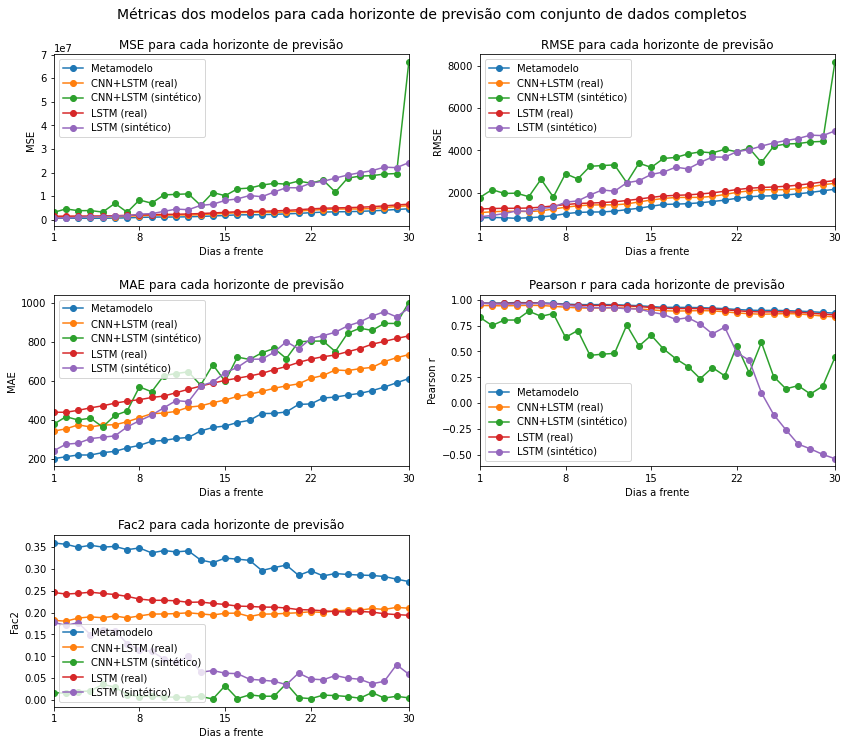

In [26]:
models_metrics = {
    'Metamodelo': metrics_metamodel,
    'CNN+LSTM (real)': metrics_cnn_lstm_real, 'CNN+LSTM (sintético)': metrics_cnn_lstm_sintetico,
    'LSTM (real)': metrics_lstm_real, 'LSTM (sintético)': metrics_lstm_sintetico
}

plot_metrics(
    models_metrics,
    title='Métricas dos modelos para cada horizonte de previsão com conjunto de dados completos'
)

Plotando médias das métricas de todos horizontes de previsão dos modelos para conjunto de dados completo.

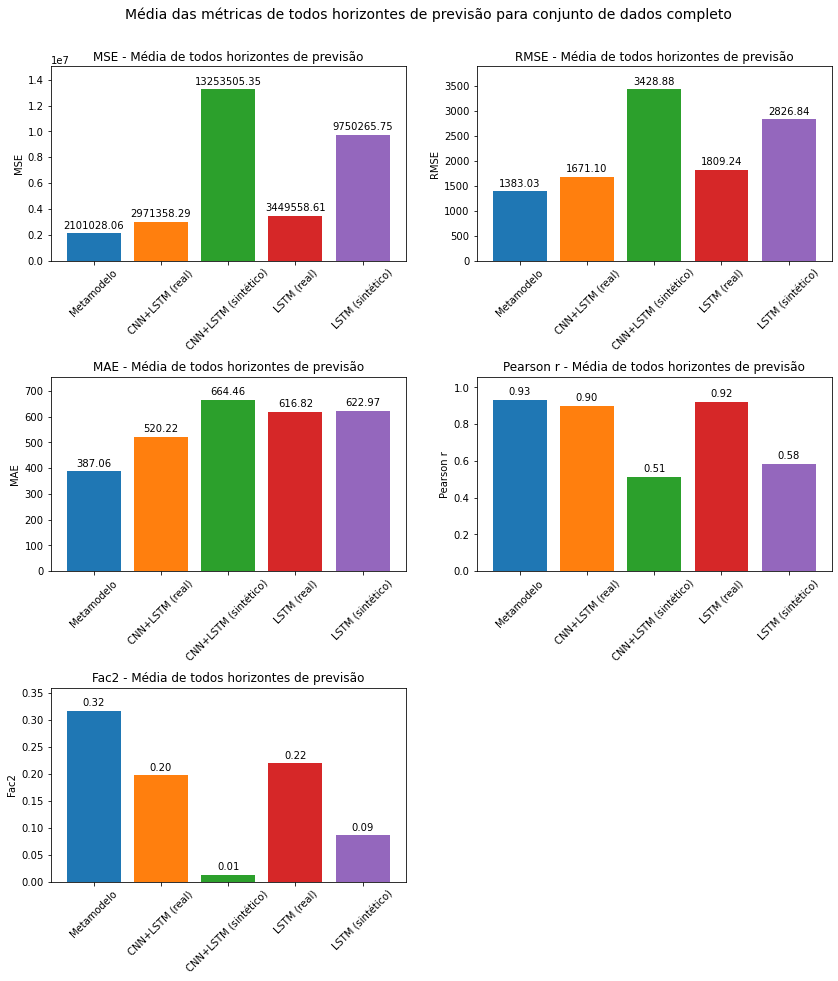

In [27]:
plot_average_metrics(
    models_metrics,
    title='Média das métricas de todos horizontes de previsão para conjunto de dados completo'
)

In [28]:
metrics_metamodel.to_csv('metrics_metamodel_confirmed.csv')

In [29]:
end = datetime.datetime.now()
print('Tempo total:', end-begin)

Tempo total: 0:05:52.530845
